<a href="https://colab.research.google.com/github/porcupinetreeforlife/Neural-Networks-and-Deep-Learning-Week-2-Assignment/blob/main/logistic_regression_cat_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression Classifier

Objective: Build a logistic regression classifier to identify images of cats.

## 1 - Import necessary libraries and load the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from google.colab import drive

%matplotlib inline

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pwd

/content


In [4]:
def load_dataset():
  train_dataset = h5py.File('/content/drive/MyDrive/Datasets/train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File('/content/drive/MyDrive/Datasets/test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
# Load the dataset from Google Drive

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

## 2 - Understand the dataset and perform any necessary transformations

y = 0, it's a 'non-cat' picture.


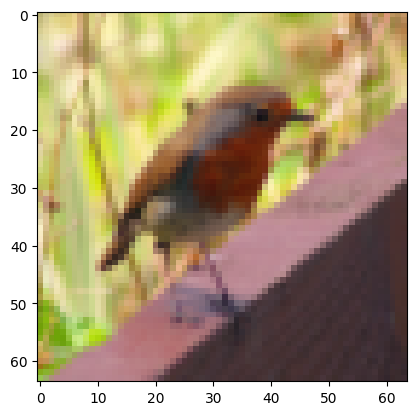

In [6]:
# Show any sample image from the dataset

index = 10
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[0, index]) +
      ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +
      "' picture.")

y = 1, it's a 'cat' picture.


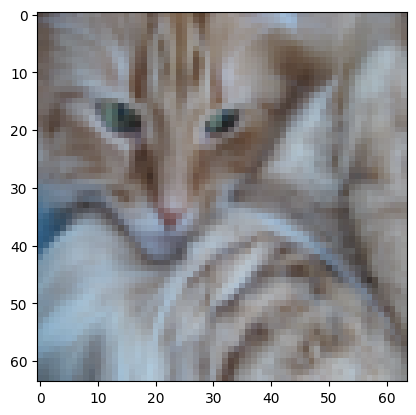

In [22]:
# Find the index of the first image of a cat and load the image

# Define the condition
condition = train_set_y[0, :] == 1

# Find all the indices that satisfy the given condition
indices = np.where(condition)

# Find the first element that satisfies the condition, provided it exists, and print the image
if len(indices[0]) > 0:
  first_index = indices[0][0]

  plt.imshow(train_set_x_orig[first_index])
  print("y = " + str(train_set_y[0, first_index]) +
        ", it's a '" + classes[np.squeeze(train_set_y[:, first_index])].decode("utf-8") +
        "' picture.")

In [16]:
# Find number of training examples, number of test examples and size of each image

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print("Number of training examples = " + str(m_train))
print("Number of test examples = " + str(m_test))
print("Size of each image = {}x{} pixels".format(num_px, num_px))
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Number of training examples = 209
Number of test examples = 50
Size of each image = 64x64 pixels
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [17]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [20]:
# Standardise the dataset by dividing each element of our array by 255

train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

## 3 - Building the algorithm

The main steps for building a Neural Network are:

- Define the model structure (such as number of input features)
- Initialize the model's parameters
- Loop:
  - Calculate current loss (forward propagation)
  - Calculate current gradient (backward propagation)
  - Update parameters (gradient descent)

We will build 1-3 separately and integrate them into one function we call model().

In [ ]:
# Define the sigmoid function

def sigmoid(z):
  """
  Compute the sigmoid of z

  Arguments:
  z -- A scalar or numpy array of any size

  Returns:
  sig_z -- Sigmoid of z
  """

  sig_z = 1 / (1 + np.exp(-z)) # Vectorise the whole operation to avoid loops

  return sig_z

In [25]:
# Initialise the parameters

def initialise_with_zeros(dim):
  """
  Initialise a numpy array of shape (dim, 1) with zeros as its elements

  Arguments:
  dim -- A scalar specifying the length of the array (or the number of parameters in this case)

  Returns:
  w -- A vector of zeros of shape (dim, 1)
  b -- A scalar corresponding to the bias term
  """

  w = np.zeros((dim, 1))
  b = 0

  assert(w.shape == (dim, 1))
  assert(isinstance(b, float) or isinstance(b, int))

  return w, b

In [ ]:
# Forward and backward propagation

def propagate(w, X, b, Y):
  """
  Implement the cost function and its gradient

  Arguments:
  w -- Weights of parameters, a numpy array of size (num_px * num_px * 3, 1)
  X -- Input vector, a numpy array of size (num_px * num_px * 3, number of examples)
  b -- Bias term, a scalar
  Y -- A "label" vector (0 if non-cat, 1 if cat), a numpy array of size (1, number of examples)

  Returns:
  cost -- The negative log-likelihood cost of the logistic function
  dw -- The partial derivative (or gradient descent) of the cost function wrt w, a numpy array of same shape as w
  db -- The partial derivative (or gradient descent) of the cost function wrt b, a scalar
  """

